**Copyright 2020 Marcel Arpogaus**

    Licensed under the Apache License, Version 2.0 (the "License");
    you may not use this file except in compliance with the License.
    You may obtain a copy of the License at
 
        http://www.apache.org/licenses/LICENSE-2.0
 
    Unless required by applicable law or agreed to in writing, software
    distributed under the License is distributed on an "AS IS" BASIS,
    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
    See the License for the specific language governing permissions and
    limitations under the License.

# Implementation of Bernstein-Polynomials as TensorFlow Probability Bijector

Normalizing flows (NF) \cite{tabak-FamilyNonparametricDensity-2013} are a type of transformation model that can be used for density estimation.
Instead of parameterizing a parametrizable desity function to fit the shape of the desired conditional probability distribution, they use a single simple PDF, usually a Gaussian, as a *base distribution* and pass it through a series of special transformation functions until it is most similar to the *data distribution*.
This composition of simple transformation functions allows NF based models to be very expressive, while staying computational efficient \cite{papamakarios-NormalizingFlowsProbabilistic-2019}.

Conditioned normalizing flows can be used for complex conditional density estimation (CDE), without assuming much about their shape \cite{hothorn-MostLikelyTransformations-2018, sick-DeepTransformationModels-2020}.
Their expressiveness is highly dependent on the flexibility of the used transformation functions.
A recent study \cite{sick-DeepTransformationModels-2020} presented a new type of flow-based transformation models especially optimized for CDE.
They joined ideas from statistical transformation models \cite{hothorn-MostLikelyTransformations-2018} and deep normalizing flows \cite{tabak-FamilyNonparametricDensity-2013} and were able to outperform existing models from both fields for complex distributions far away from Gaussian.

Compared to the statistical transformation models the proposed deep transformation model does not require predefined features and can be trained in an end-to-end fashion from complex data.
The very expressive Bernstein polynomials are used as basis transformations \cite{hothorn-MostLikelyTransformations-2018} combined in a composition of four different transformation functions to build a NF.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dependencies-&amp;-Prerequisites" data-toc-modified-id="Dependencies-&amp;-Prerequisites-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dependencies &amp; Prerequisites</a></span><ul class="toc-item"><li><span><a href="#Import-Libaries" data-toc-modified-id="Import-Libaries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import Libaries</a></span></li><li><span><a href="#Enshure-Repruducability" data-toc-modified-id="Enshure-Repruducability-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Enshure Repruducability</a></span></li><li><span><a href="#FIle-Paths" data-toc-modified-id="FIle-Paths-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>FIle Paths</a></span></li></ul></li><li><span><a href="#Function-Definitions" data-toc-modified-id="Function-Definitions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Function Definitions</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Tensorflow-Dataset-API" data-toc-modified-id="Tensorflow-Dataset-API-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Tensorflow Dataset API</a></span></li></ul></li><li><span><a href="#Berstein-Polynomials" data-toc-modified-id="Berstein-Polynomials-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Berstein Polynomials</a></span><ul class="toc-item"><li><span><a href="#Bernstein-Basis-Polynomials" data-toc-modified-id="Bernstein-Basis-Polynomials-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Bernstein Basis Polynomials</a></span></li><li><span><a href="#Berstein-Polynomial" data-toc-modified-id="Berstein-Polynomial-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Berstein Polynomial</a></span></li></ul></li><li><span><a href="#Bernstein-Bijector" data-toc-modified-id="Bernstein-Bijector-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Bernstein Bijector</a></span></li><li><span><a href="#Conditioned-Normalizing-Flow" data-toc-modified-id="Conditioned-Normalizing-Flow-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conditioned Normalizing Flow</a></span><ul class="toc-item"><li><span><a href="#Example:-Bimodal-distribution" data-toc-modified-id="Example:-Bimodal-distribution-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Example: Bimodal distribution</a></span><ul class="toc-item"><li><span><a href="#Evaluating" data-toc-modified-id="Evaluating-6.1.1"><span class="toc-item-num">6.1.1&nbsp;&nbsp;</span>Evaluating</a></span></li><li><span><a href="#Sampling" data-toc-modified-id="Sampling-6.1.2"><span class="toc-item-num">6.1.2&nbsp;&nbsp;</span>Sampling</a></span></li></ul></li></ul></li><li><span><a href="#Normalizing-Flow-Network" data-toc-modified-id="Normalizing-Flow-Network-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Normalizing Flow Network</a></span><ul class="toc-item"><li><span><a href="#Model-Definition" data-toc-modified-id="Model-Definition-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Model Definition</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Testing</a></span></li></ul></li><li><span><a href="#Berstein-Bijector-as-Loss" data-toc-modified-id="Berstein-Bijector-as-Loss-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Berstein Bijector as Loss</a></span><ul class="toc-item"><li><span><a href="#Model-Definition" data-toc-modified-id="Model-Definition-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Model Definition</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Testing</a></span></li></ul></li></ul></div>

##  Dependencies & Prerequisites

### Import Libaries

In [1]:
import os
import pandas as pd
import numpy as np

import scipy.interpolate as I
from functools import partial

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import ConnectionPatch
sns.set(style="ticks", context="paper")  # imporved plt styles

In [83]:
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import bijectors as tfb

from tensorflow.keras import Sequential, Model
from tensorflow.keras.losses import Loss
from tensorflow.keras.layers import Dense, Input, Reshape, Concatenate
from tensorflow.keras.optimizers import Adam

from tensorflow_probability.python.internal import dtype_util
from tensorflow_probability.python.internal import tensor_util

In [4]:
from tensorflow_probability.python.internal import dtype_util
from tensorflow_probability.python.internal import tensor_util

### Enshure Repruducability

In [5]:
np.random.seed(2)
tf.random.set_seed(2)
print("TFP Version", tfp.__version__)
print("TF  Version", tf.__version__)

TFP Version 0.10.0
TF  Version 2.2.0


### FIle Paths

In [6]:
gfx_path = './gfx'

## Function Definitions

We want to directly minimize the negative log-likelihood:

In [7]:
def negloglik(y_true, y_hat):
    nll = -y_hat.log_prob(y_true)
    return nll

Small helper function to store plots as PNG-Image:

In [8]:
def savefig(fn):
    return plt.savefig(os.path.join(gfx_path, fn + '.png'), transparent=True)

In [9]:
def vizualize_flow_from_z_domain(flow):
    bijector = flow.bijector
    base_dist = flow.distribution

    n = 1000

    # z ~ p_z
    z_samples = np.linspace(-3, 3, n, dtype=np.float32)  # flow.sample(n)
    z_probs = base_dist.prob(z_samples)

    # y = h(z)
    y_samples = np.squeeze(bijector.forward(z_samples))

    # p_y(y) = p_z(h^-1(y))*|h^-1'(y)| = p_z(z)*|h^-1'(y)|
    ildj = bijector.inverse_log_det_jacobian(y_samples[..., None], 1)
    log_prob = base_dist.log_prob(z_samples)
    log_prob = log_prob + ildj

    y_probs = np.exp(log_prob)

    fig = plt.figure(figsize=(8, 8))

    gs1 = gridspec.GridSpec(2, 2)

    b_ax = fig.add_subplot(gs1[0, 1])
    b_ax.spines['top'].set_color('none')  # don't draw spine
    b_ax.spines['right'].set_color('none')  # don't draw spine
    b_ax.spines['bottom'].set_position(('outward', 10))
    b_ax.spines['left'].set_position(('outward', 10))

    b_ax.set_xlabel('z')
    b_ax.set_ylabel('y')

    y_ax = fig.add_subplot(gs1[0, 0], sharey=b_ax)
    y_ax.axis('off')
    plt.gca().invert_xaxis()

    z_ax = fig.add_subplot(gs1[1, 1], sharex=b_ax)
    z_ax.axis('off')
    plt.gca().invert_yaxis()

    gs1.tight_layout(fig)

    z_ax.plot(z_samples, z_probs)
    b_ax.plot(z_samples, y_samples)
    y_ax.plot(y_probs, y_samples)

    mu_z = base_dist.mean()

    mu_y = bijector.forward(mu_z)

    p_mu_z = base_dist.prob(mu_z)
    p_mu_y = np.exp(base_dist.log_prob(mu_z) +
                    bijector.inverse_log_det_jacobian(mu_y, 1))

    cp_kwds = dict(
        color='darkgray',
        lw=1,
        ls='--',
        arrowstyle='->'
    )

    project_y = ConnectionPatch(
        xyA=(mu_z, p_mu_z),
        xyB=(mu_z, mu_y),
        coordsA='data',
        coordsB='data',
        axesA=z_ax,
        axesB=b_ax,
        **cp_kwds
    )
    z_ax.add_artist(project_y)

    project_y = ConnectionPatch(
        xyA=(mu_z, mu_y),
        xyB=(p_mu_y, mu_y),
        coordsA='data',
        coordsB='data',
        axesA=b_ax,
        axesB=y_ax,
        **cp_kwds
    )
    b_ax.add_artist(project_y)

    return fig

In [10]:
def plot_chained_bijectors(flow):
    chained_bijectors = flow.bijector.bijector.bijectors
    base_dist = flow.distribution
    cols = len(chained_bijectors) + 1
    fig, ax = plt.subplots(1, cols, figsize=(4*cols, 4))

    n = 200

    z_samples = np.linspace(-3, 3, n).astype(np.float32)
    log_probs = base_dist.log_prob(z_samples)

    ax[0].plot(z_samples, np.exp(log_probs))

    zz = z_samples[..., None]
    ildj = 0.
    for i, (a, b) in enumerate(zip(ax[1:], chained_bijectors)):
        # we need to use the inverse here since we are going from z->y!
        z = b.inverse(zz)
        ildj += b.forward_log_det_jacobian(z, 1)
        #print(z.shape, zz.shape, ildj.shape)
        a.plot(z, np.exp(log_probs + ildj))
        a.set_title(b.name.replace('_', ' '))
        a.set_xlabel(f'$z_{i}$')
        a.set_ylabel(f'$p(z_{i+1})$')
        zz = z
    fig.tight_layout()

In [11]:
def plot_flow(flow, y, ax=plt, color='skyblue'):
    base_dist = flow.distribution
    bijector = flow.bijector

    dense_y = flow.prob(y).numpy()

    mu = np.squeeze(bijector.forward(base_dist.mean()))
    plus_sd = np.squeeze(bijector.forward(
        base_dist.mean() + base_dist.stddev()))
    minus_sd = np.squeeze(bijector.forward(
        base_dist.mean() - base_dist.stddev()))

    ax.plot(
        [mu, mu],
        [np.min(dense_y),
         flow.prob(mu.reshape(-1, 1)).numpy()],
        color='black',
        lw=2
    )
    ax.plot(
        [plus_sd, plus_sd],
        [np.min(dense_y), flow.prob(plus_sd.reshape(-1, 1)).numpy()],
        '--',
        color='green'
    )
    ax.plot(
        [minus_sd, minus_sd],
        [np.min(dense_y), flow.prob(minus_sd.reshape(-1, 1)).numpy()],
        '--',
        color='green'
    )

    def quant(p):
        q = bijector.forward(base_dist.quantile(p))
        return np.squeeze(q)

    qs = [.05, .1, .2, .3, .4]
    ax.fill_between(
        np.squeeze(y),
        np.squeeze(dense_y),
        np.min(dense_y),
        fc=color,
        alpha=max(qs)
    )
    for i, q in enumerate(sorted(qs)):
        ax.fill_between(
            np.squeeze(y),
            np.squeeze(dense_y),
            np.min(dense_y),
            where=(
                (np.squeeze(y) > quant(q)) & (np.squeeze(y) < quant(1-q))
            ),
            fc=color,
            alpha=q / max(qs)
        )

    ax.plot(
        y,
        dense_y,
        '-',
        color=color,
        linewidth=2
    )

## Data

Classic dataset conatining the waiting time between eruptions and the duration of the eruption for the [Old Faithful Geyser](https://en.wikipedia.org/wiki/Old_Faithful) in [Yellowstone National Park](https://en.wikipedia.org/wiki/Yellowstone_National_Park).

Extrected form the [built-in dataset in R](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/faithful.html).

Reference: \cite{azzalini-LookDataOld-1990}

In [12]:
y = np.asarray(
    (0.6694, 0.3583, 0.6667, 0.6667, 0.6667, 0.3333, 0.7306, 0.7139, 0.3389, 0.8056, 0.3056, 0.9083, 0.2694, 0.8111,
     0.7306, 0.2944, 0.7778, 0.3333, 0.7889, 0.7028, 0.3167, 0.8278, 0.3333, 0.6667, 0.3333, 0.6667, 0.4722, 0.75,
     0.6778, 0.6194, 0.5861, 0.7444, 0.3694, 0.8139, 0.4333, 0.6917, 0.3667, 0.7944, 0.3056, 0.7667, 0.3778, 0.6889,
     0.3333, 0.6667, 0.3333, 0.6667, 0.3139, 0.7111, 0.3472, 0.7444, 0.4167, 0.6667, 0.2944, 0.7222, 0.3639, 0.7472,
     0.6472, 0.5556, 0.6222, 0.6667, 0.325, 0.8778, 0.3333, 0.6667, 0.3333, 0.6667, 0.3333, 0.6667, 0.5889, 0.3611, 0.75,
     0.3361, 0.6917, 0.7, 0.7222, 0.3222, 0.775, 0.6361, 0.6722, 0.6944, 0.7778, 0.3028, 0.6667, 0.5, 0.6667, 0.3333, 0.7417,
     0.3417, 0.7083, 0.3194, 0.7778, 0.2889, 0.7306, 0.2944, 0.7667, 0.3111, 0.7417, 0.2722, 0.8389, 0.3028, 0.85, 0.2722, 0.7139,
     0.3333, 0.6667, 0.3333, 0.7556, 0.3333, 0.6667, 0.4889, 0.7889, 0.65, 0.325, 0.6861, 0.3, 0.7778, 0.3056, 0.7833, 0.3528, 0.7972,
     0.3028, 0.6833, 0.775, 0.6667, 0.3333, 0.6667, 0.6667, 0.7028, 0.6889, 0.6556, 0.625, 0.7361, 0.4111, 0.6944, 0.6333, 0.7194,
     0.6444, 0.7806, 0.2833, 0.8278, 0.7111, 0.7639, 0.6667, 0.6667, 0.6667, 0.6667, 0.3306, 0.7667, 0.1389, 0.8194, 0.2889, 0.7639,
     0.2833, 0.7917, 0.3056, 0.75, 0.3111, 0.7417, 0.7417, 0.6667, 0.8, 0.6667, 0.6667, 0.3333, 0.6667, 0.3222, 0.7639, 0.3333, 0.6167,
     0.4778, 0.8056, 0.575, 0.7306, 0.3, 0.7333, 0.4139, 0.7528, 0.35, 0.725, 0.7278, 0.2972, 0.8194, 0.3028, 0.6667, 0.6667, 0.6667, 0.6444,
     0.3083, 0.7833, 0.3361, 0.7444, 0.3111, 0.6944, 0.3167, 0.7083, 0.5417, 0.7028, 0.3139, 0.8306, 0.3083, 0.6667, 0.3278, 0.7944, 0.6667, 0.3333,
     0.6667, 0.6667, 0.3972, 0.7361, 0.7028, 0.7278, 0.3333, 0.7417, 0.2917, 0.75, 0.2694, 0.7833, 0.4278, 0.6167, 0.7056, 0.3222, 0.725, 0.6667, 0.6667,
     0.6667, 0.7028, 0.6667, 0.6889, 0.3139, 0.7444, 0.325, 0.7028, 0.2861, 0.7417, 0.7083, 0.6611, 0.7306, 0.3278, 0.7417, 0.7111, 0.3194, 0.7361, 0.5,
     0.6667, 0.3333, 0.6667, 0.5472, 0.3056, 0.7694, 0.3056, 0.7694, 0.7667, 0.7083, 0.3222, 0.8306, 0.3278, 0.7167, 0.7, 0.7556, 0.7333, 0.7694, 0.3333,
     0.6667, 0.6667, 0.6528, 0.3333, 0.75, 0.3, 0.6667, 0.4583, 0.7889, 0.6611, 0.325, 0.8278, 0.3083, 0.8, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667,
     0.6667, 0.3333, 0.6667, 0.3222, 0.7222, 0.2778, 0.7944, 0.325, 0.7806, 0.3222, 0.7361, 0.3556, 0.6806, 0.3444, 0.6667, 0.6667, 0.3333),
    np.float32
)

In [13]:
x = np.ones((y.shape[0], 1))

### Tensorflow Dataset API

[`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) API supports writing descriptive and efficient input pipelines

In [14]:
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.shuffle(buffer_size=len(y))
dataset = dataset.batch(32)
dataset = dataset.prefetch(1)
dataset

<PrefetchDataset shapes: ((None, 1), (None,)), types: (tf.float64, tf.float32)>

In [15]:
x_sample, y_sample = next(dataset.as_numpy_iterator())
x_sample.shape, y_sample.shape

((32, 1), (32,))

## Berstein Polynomials

### Bernstein Basis Polynomials

The Bernstein polynomial basis has been introduced by Sergei Natanovich Bernstein over 100 years ago to facilitate a constructive proof of the Weierstrass approximation theorem.
It turned out as a remarkable method for approximating any continuous function, to the desired accuracy over finite domains, and firstly found application in computer-aided geometric design.
Due to its excellent numerical stability properties, the diversification of its repertoire of applications steadily increased.
A comprehensible survey of the historical development and current state of theory, algorithms, and applications can be found in \cite{farouki-BernsteinPolynomialBasis-2012}.
The Bernstein basis of degree $M$ on $x\in[0,1]$ is defined by:

\begin{equation}
    \operatorname{Be}_{k}^{M}(x):=
        \left(%
            \begin{array}{l}
                M \\
                k
            \end{array}%
        \right)
        (1-x)^{M-k} x^{k}, \quad \text{with} \quad k=0, \ldots, M
\end{equation}

The Bernstein basis polynomials have two fundamental properties, firstly they are non–negative on $x\in[0,1]$ and secondly they form a partition of unity, hence

\begin{equation}
    \sum_{i=0}^{n} Be_{i}^{M}(t)=1.
\end{equation}

The five Bernstein basis polynomials of degree $M=5$ on $x\in[0,1]$ along with the cumulative sum are are shown in the following plot.

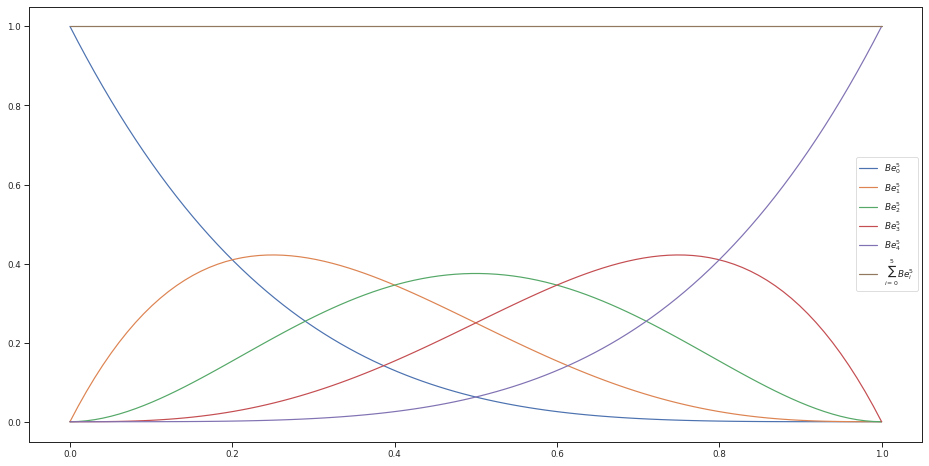

In [16]:
M = 5
x = np.linspace(0, 1, 100)
d = {}
for i in range(M):
    c = np.zeros(M).reshape(-1, 1)
    c[i] = 1
    bp = I.BPoly(c, [0, 1])
    d[f'$Be^{M}_{i}$'] = bp(np.linspace(0, 1, 100))

df = pd.DataFrame(d, index=x)
df[f'$\sum^{M}_{{i=0}} Be^{M}_i$'] = df.sum(axis='columns')
df.plot(figsize=(16, 8))
savefig('bernstein_basis')

### Berstein Polynomial

The Bernstein basis polynomials of degree $M$ form a basis of polynomials of degree at most $M$ with real coefficients. A linear combination of Bernstein basis polynomials 

\begin{equation}
    b_{M}(x)=\sum_{i=0}^{M} \vartheta_{i} \operatorname{Be}_{i}^{M}
\end{equation}

is then called a Bernstein polynomial of degree $M$, with the Bernstein coefficients $\vartheta_\nu$\cite{farouki-BernsteinPolynomialBasis-2012}.
The following plot sows the Bernstein polynomials with increasing order $M=1,\ldots,5$, and random integer coefficients $\theta$.

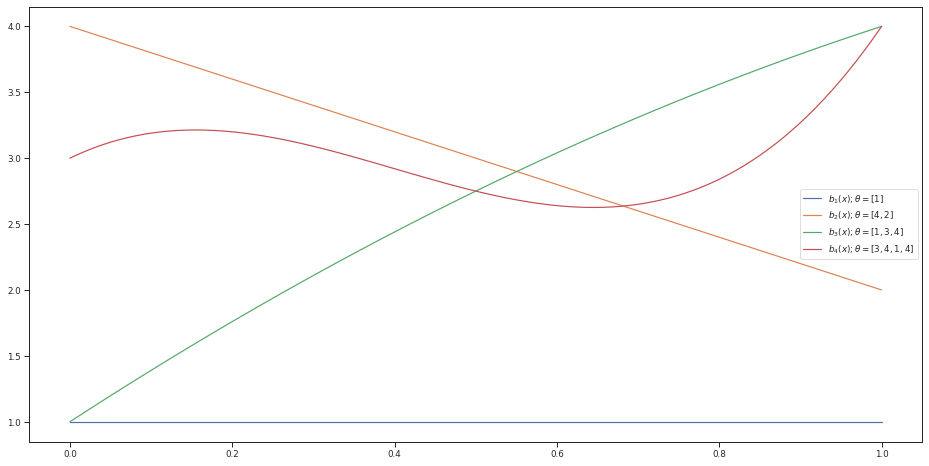

In [17]:
M = 5
x = np.linspace(0, 1, 100)
d = {}
for i in range(1, M):
    c = np.random.randint(1, M, (i, 1))
    bp = I.BPoly(c, [0, 1])
    d[f'$b_{i}(x); \\theta=[{",".join(c.flatten().astype(str))}]$'] = bp(
        np.linspace(0, 1, 100))

df = pd.DataFrame(d, index=x)
df.plot(figsize=(16, 8))
savefig('bernstein_poly')

## Bernstein Bijector

Implementing the Bernstein Polynomial using the [`tf.Bijector`](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/Bijector) interface for transformations of a `Distribution` sample.

In [18]:
class BernsteinBijector(tfb.Bijector):

    def __init__(self,
                 len_theta,
                 theta,
                 validate_args=False,
                 name='bernstein_bijector'):
        with tf.name_scope(name) as name:
            dtype = dtype_util.common_dtype([theta], dtype_hint=tf.float32)

            super().__init__(
                forward_min_event_ndims=0,
                is_constant_jacobian=True,
                validate_args=validate_args,
                dtype=dtype,
                name=name)

            # Bernstein coefficents
            len_theta = len_theta
            self.M = len_theta - 1
            self.theta = tensor_util.convert_nonref_to_tensor(
                theta, dtype=dtype, name='shift')

            # Bernstein polynomials of order M, generated by the M + 1 beta-densities
            self.beta_dist_h = tfd.Beta(
                range(1, len_theta + 1), range(len_theta, 0, -1))

            # Deviation of the Bernstein polynomials
            self.beta_dist_h_dash = tfd.Beta(
                range(1, self.M + 1), range(self.M, 0, -1))

            # Cubic splines are used to approximate the inverse
            self.interp = None

    def gen_inverse_interpolation(self):
        y_fit = np.linspace(.0, 1, self.M * 10,
                            dtype=np.float32)[..., tf.newaxis]

        z_fit = self.forward(y_fit)
        self.z_min = np.min(z_fit)
        self.z_max = np.max(z_fit)

        interp = I.interp1d(
            x=np.squeeze(z_fit),
            y=np.squeeze(y_fit),
            kind='cubic'
        )

        def ifn(x):
            return interp(x).astype(np.float32)

        self.interp = ifn

    def _inverse(self, z):
        if tf.executing_eagerly():
            if self.interp is None:
                self.gen_inverse_interpolation()
            z = tf.clip_by_value(z, self.z_min + 1E-5, self.z_max - 1E-5)
            return self.interp(z)
        else:
            return z

    def _forward(self, y):
        # [B,1] or [B,]
        y = tf.reshape(y, (-1, 1))  # [B,] -> [B,1]

        y = tf.clip_by_value(y, 1E-5, 1.0 - 1E-5)
        by = self.beta_dist_h.prob(y)
        z = tf.reduce_mean(by * self.theta, axis=1)

        return z[..., tf.newaxis]  # [B,1]

    def _forward_log_det_jacobian(self, y):
        # [B,1] or [B,]
        y = tf.reshape(y, (-1, 1))  # [B,] -> [B,1]

        y = tf.clip_by_value(y, 1E-5, 1.0 - 1E-5)
        by = self.beta_dist_h_dash.prob(y)
        dtheta = self.theta[:, 1:] - self.theta[:, 0:-1]
        ldj = tf.math.log(tf.reduce_sum(by * dtheta, axis=1))

        return ldj[..., tf.newaxis]

    @classmethod
    def constrain_theta(cls, theta_unconstrained, fn=tf.math.softplus):
        # Calclutes theta_1 = h_1, theta_k = theta_k-1 + exp(h_k)
        bs = tf.shape(theta_unconstrained)[0]

        d = tf.concat((tf.zeros((bs, 1)),
                       theta_unconstrained[:, 0:1],
                       fn(theta_unconstrained[:, 1:])), axis=1)
        return tf.cumsum(d[:, 1:], axis=1)

A closed-form solution for the inversion of higher-order Bernstein polynomials is not known.
The monotonicity of a Bernstein polynomial can been ensured via linear constraints what makes it technically invertible.
Since extensions of the Bernstein polynomials for interpolations with *piecewise-polynomial functions* (B-Splines) exists \cite{farouki-BernsteinPolynomialBasis-2012} they are used to approximate the inverse of the Bernstein polynomial.
In the implementation above cubic splines have been used for the approximation using a linear interval of $10$ times the polynomial order $M$ points.

tf.Tensor(
[[0.05827069 0.919791   1.8284149  3.0512545  3.1894658  4.144794
  5.0759916  6.156185   6.5124607 ]], shape=(1, 9), dtype=float32)


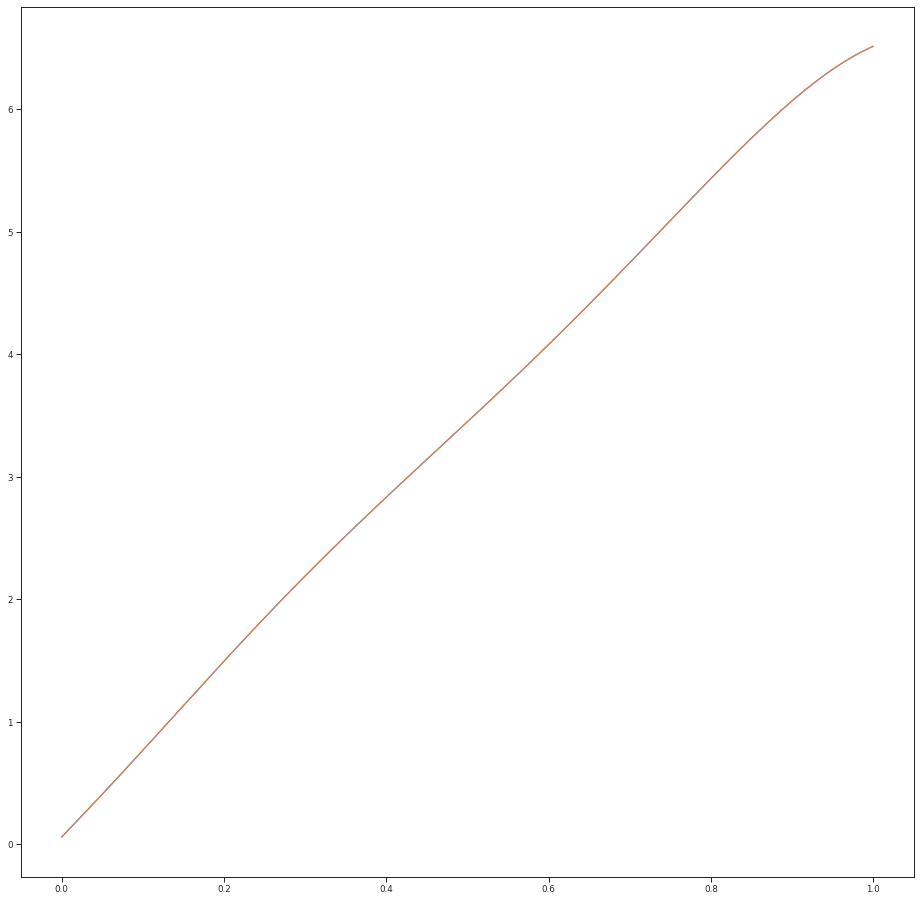

In [62]:
M = 9
theta = BernsteinBijector.constrain_theta(
    np.random.normal(0, 1, (1, M)).astype(np.float32)
)
print(theta)
bs = BernsteinBijector(
    len_theta=M,
    theta=theta
)
yy = np.linspace(0, 1, 200, dtype=np.float32)
zz = bs.forward(yy)
# Prevent caching -> use interpolation
zi = zz + 1e-15 * np.random.random(zz.shape)
yyy = bs.inverse(zi)

plt.figure(figsize=(16, 16))
plt.plot(yy, zz)
plt.plot(yyy, zi)

In [69]:
f'The MSE of the interpolation in this example is {np.sum((np.squeeze(yyy)-yy)**2):.3e}$.'

'The MSE of the interpolation in this example is 7.231e-10$.'

## Conditioned Normalizing Flow

Models based on NF have only gained little attention in the research community for CDE and have predominantly been used for variational inference\cite{kingma-ImprovingVariationalInference-2017,rezende-VariationalInferenceNormalizing-2016} or modeling of complex multi-modal unconditional distributions, for example for image generation\cite{kingma-GlowGenerativeFlow-2018, dinh-DensityEstimationUsing-2017} or speech synthesis\cite{oord-ParallelWaveNetFast-2017,oord-WaveNetGenerativeModel-2016}.
Compared to conditional VAE\cite{sohn-LearningStructuredOutput-2015} and conditional GAN\cite{mirza-ConditionalGenerativeAdversarial-2014} NF based models explicitly estimate the distribution and hence the Negative logarithmic likelihood becomes tractable and can be used as loss-function, what makes them attractive for CDE.
Very recent research applied NF in that context and has shown very promising results \cite{rothfuss-NoiseRegularizationConditional-2020, rasul-MultivariateProbabilisticTime-2020, trippe-ConditionalDensityEstimation-2018}.

In the original formulation of NF by \cite{tabak-FamilyNonparametricDensity-2013}, rich density approximations were constructed, by transforming a simple initial density, into a more complex one.
This implementation of flows is particularly efficient for generating new samples from the learned data distribution but limited by the inefficiency of evaluating the likelihood of externally provided data since it requires inverting each $f_n$.
Depending on the specific implementation it may be sufficient to reverse that direction, to allow the evaluation of likelihoods in constant time.
The following illustration  shows a inverse conditioned normalizing flow model, transforming a complex conditioned distribution $p_y(y|x)$ step by step to a simple Gaussian distribution $p_z(z|x)$, conditioned on some value $x$. The visualization was inspired by \cite{weng-FlowbasedDeepGenerative-2018}.

![](gfx/conditioned_normalizing_flow.svg)

Defining the forward mapping from the target $y$ to the base distribution, allows the density to be evaluated in constant time, even for complex transformation functions, which leads to

\begin{equation}
    z = t(y,\boldsymbol{\theta}_x)\qquad\text{with}\qquad y \sim p_z(z)
\end{equation}

with $t$ being a composition of $K$ bijectors $f_1(y, \boldsymbol{\theta}_{1}) \cdots f_K(y, \boldsymbol{\theta}_{K})$, parameterized with the corresponding parameter vector $\boldsymbol{\theta}_n=[\vartheta_1,\ldots,\vartheta_l]$.
Conditioning the transformed \emph{base distribution} $p_z(z|\mathbf{x})$ on the vector $\mathbf{x}$ is then achieved by, conditioning the parameters $\boldsymbol{\theta}_n$ on them.
A neural network can be trained to learn the mapping from the input $\mathbf{x}$ to the parameter vectors $h(\mathbf{x},\omega)=\boldsymbol{\theta}_x=[\theta_{1,x},\ldots,\theta_{K,x}]^T$, which is then used to parametrize the transformer functions $f_n(y,\theta_{n,x})$.

\begin{equation}
    \begin{aligned}
        z &= t(y|x,\boldsymbol{\theta}_x) = (f_K \circ f_{K-1} \circ \cdots \circ f_1)(y|x,\boldsymbol{\theta}_x)\\
          &= t(y,h(\mathbf{x},\omega)) = f_K(\cdots(f_1(y,\theta_{1,x} )\cdots)\theta_{M,x}
    )
    \end{aligned}
\end{equation}.

This way each input $\mathbf{x}$ yields a different parametrization of $t$ and thus results in a different transformation.

The expressiveness of the NF is highly dependent on the used bijectors.
A promising transformation model building upon the works from \cite{hothorn-MostLikelyTransformations-2018} is  used the very expressive Bernstein polynomials are used as basis transformations combined in a composition of four different transformation functions to build the flow \cite{sick-DeepTransformationModels-2020}.
By joining these ideas from statistical transformation models \cite{hothorn-MostLikelyTransformations-2018} and deep normalizing flows \cite{tabak-FamilyNonparametricDensity-2013}, they were able to outperform existing models from both fields for complex distributions far away from Gaussian.

First a affine transformation $f_1$ is used, which scales and shifts $y$ followed by a sigmoid function to ensure the restriction to the valid range $[0, 1]$:

\begin{equation}
   \sigma \circ  f_1: \quad \tilde{y} = \sigma(a(\mathbf{x}) \cdot y - b(\mathbf{x}))
\end{equation}

To condition the scale and shift parameters $a$ and $b$ in the input vector $\mathbf{x}$ they are controlled by the output of an artificial neural network with input $\mathbf{x}$.
To ensure monotonicity the softplus activation function is used for $a$, the activation of $b$ is linear.

The second transformation $f_2$ is the transformation consisting of a Bernstein polynomial with $M+1$
parameters $\vartheta_0 , \vartheta_1,\ldots \vartheta_M$ which again are controlled by a neural network.

\begin{equation}
    f_{2}: \quad \tilde{z}=\frac{1}{M+1} \sum_{i=0}^{M} \operatorname{Be}_{i}^M(\tilde{y}) \vartheta_{i}(\mathbf{x})
\end{equation}

$Be$ is the Bernstein polynomials of order $M$, generated by the $M + 1$ beta-densities

\begin{equation}
    \operatorname{Be}_i^M(\tilde{y})=f_{i+1, M-i+1}(\tilde{y})
\end{equation}

Maintaining the monotonicity for the invertibility of $f_2$ can then easily be achieved via a linear constraint on the basis coefficients, a circumstance that the implementation in \cite{sick-DeepTransformationModels-2020} also took advantage of by simply enforcing that the coefficients $\theta=[\vartheta_1,\ldots\vartheta_M]^T$ of the polynomial are in increasing order.

The last transformation in the chain $f_3$ is again a scale and shift transformation to force the output of $f_3$ into the range of the standard normal distribution.

\begin{equation}
    f_{3}: \quad z=\alpha(\mathbf{x}) \cdot \tilde{z}-\beta(\mathbf{x})
\end{equation}

The parameters $\alpha$ and $\beta$ are again controlled by a neural network, where the
softplus transformation is used to guarantee a positive $\alpha$.
The first experiments showed that the third bijector is not necessary for the performance but accelerates training.

The final transformation function $t(y,h(\mathbf{x},\omega)): y \rightarrow z$ is then obtained by chaining the single transformation functions.

\begin{equation}\label{eq-sick-flow}
    \begin{aligned}
        z &= t(y,h(\mathbf{x},\omega)) = (f_3 \circ f_2 \circ \sigma \circ f_1)(y,h(\mathbf{x},\omega))\\
          &= (f_{3, \alpha(x), \beta(x)} \circ f_{2, \vartheta_{0}(x), \ldots, \vartheta_{M}(x)} \circ \sigma \circ f_{1, a(x), b(x)})(y,x)
    \end{aligned}
\end{equation}.

Illustration of a flow transforming from a bimodal distribution, to a standard Gaussian, taken from \cite{sick-DeepTransformationModels-2020}:

![Visual representation of the normalizing flow](gfx/sick_deep_transformation_models_2020_method.svg)

In [21]:
def bernstein_flow(M, a1, b1, theta, a2, b2, name='bsf'):
    bijectors = []

    # f1: ŷ = sigma(a1(x)*y - b1(x))
    f1_scale = tfb.Scale(
        a1,
        name=f'{name}_f1_scale'
    )
    bijectors.append(f1_scale)
    f1_shift = tfb.Shift(
        b1,
        name=f'{name}_f1_shift'
    )
    bijectors.append(f1_shift)
    bijectors.append(tfb.Sigmoid())

    # f2: ẑ = Berstein
    f2 = BernsteinBijector(
        len_theta=M,
        theta=theta,
        name=f'{name}_f2'
    )
    bijectors.append(f2)

    # f3: z = a2(x)*ẑ - b2(x)
    f3_scale = tfb.Scale(
        a2,
        name=f'{name}_f3_scale'
    )
    bijectors.append(f3_scale)
    f3_shift = tfb.Shift(
        b2,
        name=f'{name}_f3_shift'
    )
    bijectors.append(f3_shift)

    bijectors = list(reversed(bijectors))
    return tfd.TransformedDistribution(
        distribution=tfd.Normal(loc=0., scale=1.),
        bijector=tfb.Invert(tfb.Chain(bijectors)),
        event_shape=[1],
        name='NormalTransformedDistribution')

### Example: Bimodal distribution

In [32]:
a1 = 3
b1 = -4
theta = np.array([[-2] +  np.linspace(0.3,0.5,7).tolist() + [2]], dtype=np.float32)
a2 = 3
b2 = 0
theta

array([[-2.        ,  0.3       ,  0.33333334,  0.36666667,  0.4       ,
         0.43333334,  0.46666667,  0.5       ,  2.        ]],
      dtype=float32)

#### Evaluating

\begin{equation}
    p_y(y|\mathbf{x}) = p_z(t(\mathbf{y,\boldsymbol{\theta}_x})) \left|\det\nabla{t}(\mathbf{x},\boldsymbol{\theta}_x)\right|
\end{equation}

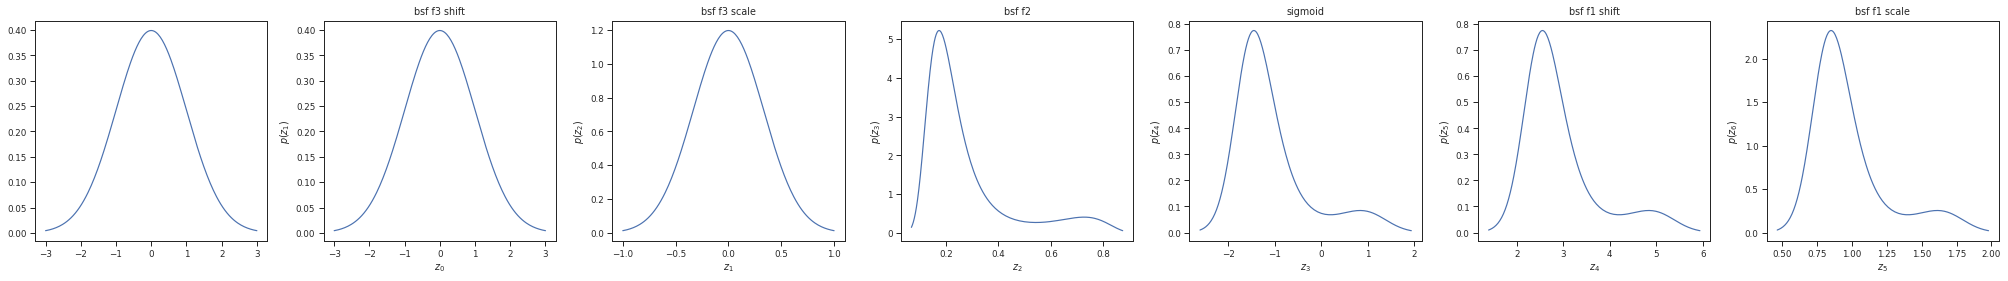

In [33]:
flow = bernstein_flow(
    M=theta.shape[1],
    a1=a1,
    b1=b1, 
    theta=theta,
    a2=a2,
    b2=b2)
plot_chained_bijectors(flow)

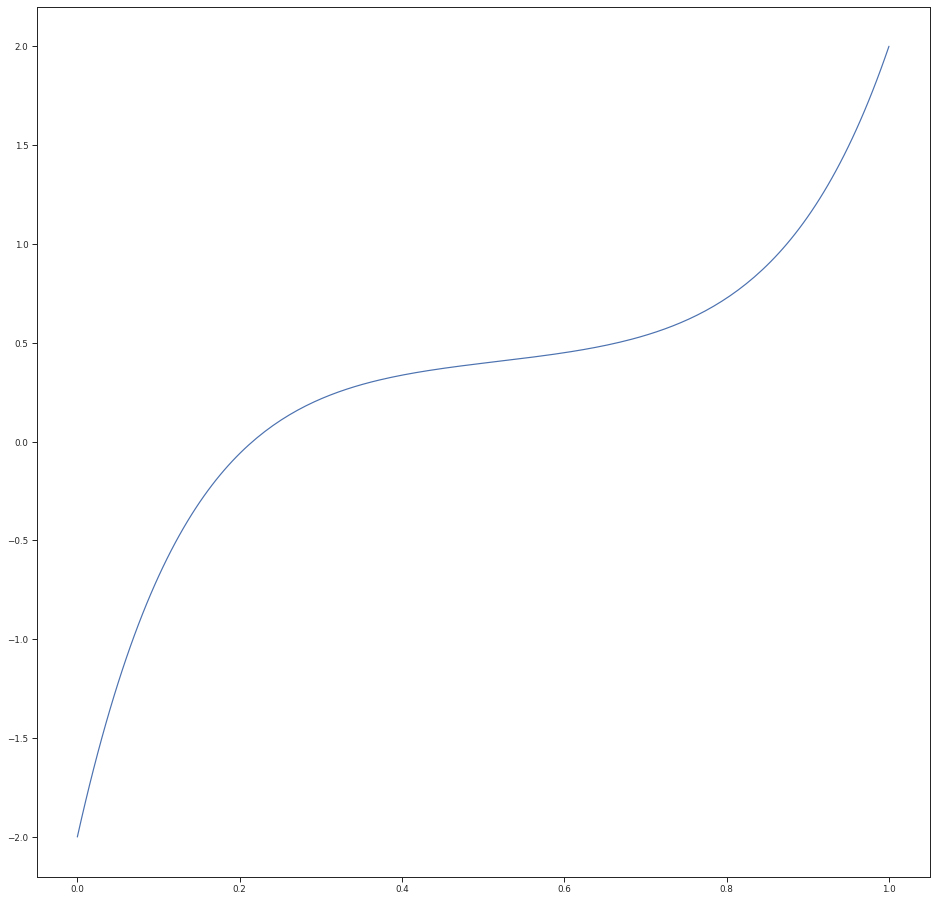

In [34]:
bs=flow.bijector.bijector.bijectors[2]
zz = bs.forward(yy)
plt.figure(figsize=(16, 16))
plt.plot(yy, zz)

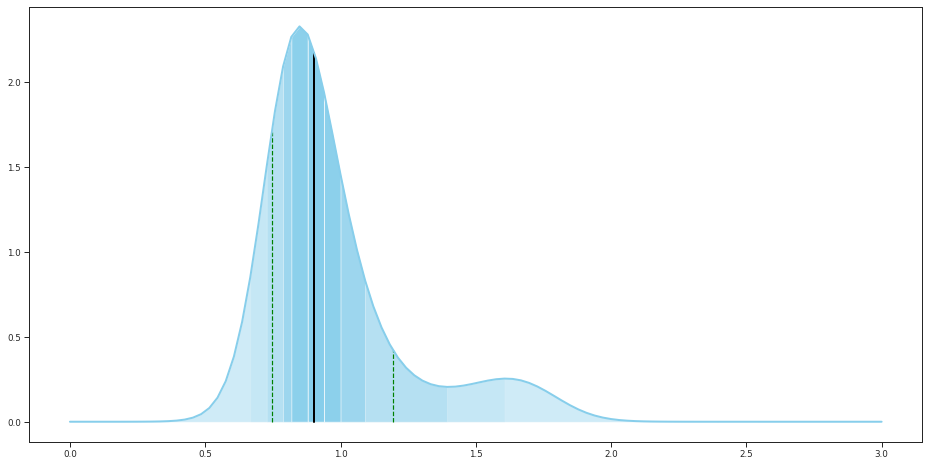

In [45]:
n = 100
y_samples = np.linspace(0, 3, n, dtype=np.float32)
y_probs = flow.prob(y_samples[...,None])

plt.figure(figsize=(16,8))
plot_flow(flow,y_samples[...,None])

In [46]:
dy = y_samples[1]-y_samples[0]
sum(y_probs)*dy

<tf.Tensor: shape=(), dtype=float32, numpy=0.9999998>

#### Sampling
\begin{equation}
    y\sim p_y(y|x) = t^{-1}(z,\boldsymbol{\theta}_x)\qquad\text{with}~z \sim p_z(z)
\end{equation}

In [47]:
samples=flow.sample(5000)

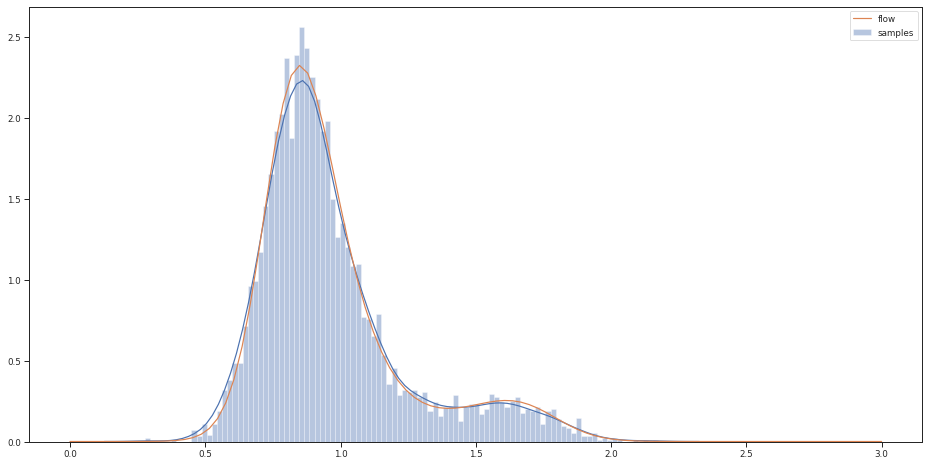

In [48]:
fig = plt.figure(figsize=(16,8))
sns.distplot(samples.numpy().flatten(),bins=100,label='samples')

plt.plot(y_samples, y_probs,label='flow')
plt.legend()

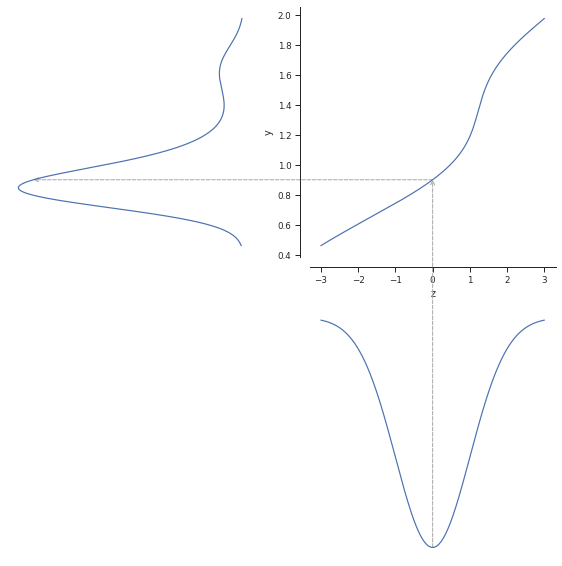

In [49]:
fig=vizualize_flow_from_z_domain(flow)

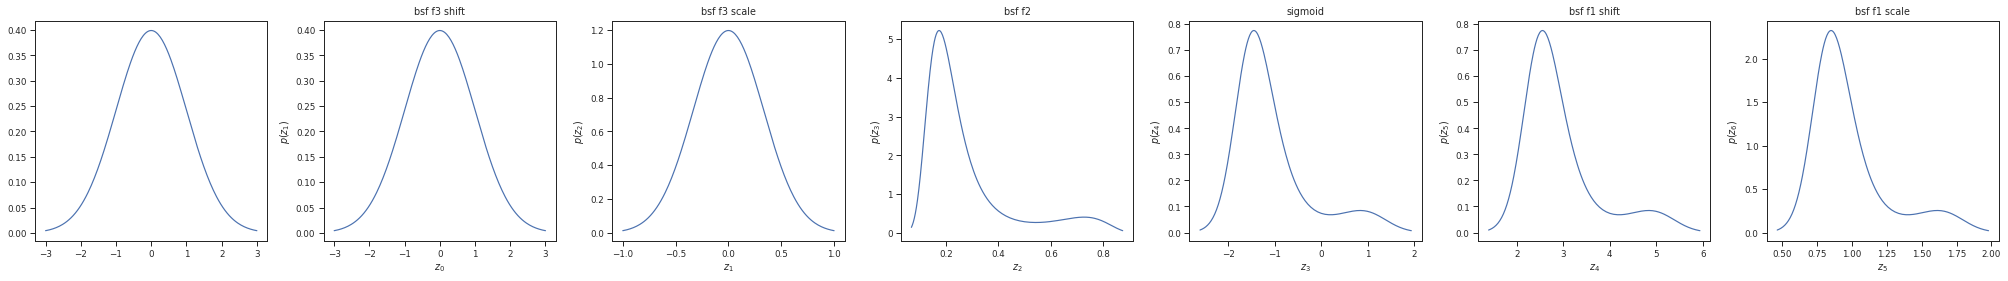

In [50]:
plot_chained_bijectors(flow)

## Normalizing Flow Network

All the parameters $a,b,\theta,\alpha$ and $\beta$ are obtained from the outputs of a artificial neural network with input $\mathbf{x}$.
The positivity of $a$ and $\alpha$ is ensured by passing the raw output $\tilde{a}$ and $\tilde{\alpha}$ through a softplus activation function.
Constraining the Bernstein parameters $\theta$ to monotone increasing order is.
If $\tilde\vartheta_k$ is the $k$-th output of the parameter network for $f_2$, choosing $\vartheta_k = \vartheta_{k-1} + \exp(\tilde\vartheta_k)$ for $k>0$, dos the trick.
The first output can stay unchanged and defines $\vartheta_0=\tilde\vartheta_0$.

![](gfx/sick_architecture.svg)

In [51]:
# basis distribution
base_dist = tfd.Normal(0, 1)  # The distribution of z

### Model Definition

In [75]:
from functools import partial
neurons = 32  # Neurons of the DNN hidden layers
M = 9         # Order of Bernstin Polynomial


OutputLayer = partial(
    tf.keras.layers.Dense,
    activation="linear",
    use_bias=False,
    # kernel_regularizer=tf.keras.regularizers.l2(0.0001)
)

inputs = tf.keras.layers.Input(shape=(1,))

a1 = OutputLayer(
    1,
    activation='softplus',
    name="a1"
)(inputs)
b1 = OutputLayer(
    1,
    name="b1"
)(inputs)

theta = OutputLayer(
    M,
    activation=BernsteinBijector.constrain_theta,
    name="theta"
)(inputs)

a2 = OutputLayer(
    1,
    activation='softplus',
    name="a2"
)(inputs)
b2 = OutputLayer(
    1,
    name="b2"
)(inputs)


def bernstein_lambda(pvector):
    a1, b1, theta, a2, b2 = pvector
    return bernstein_flow(
        M,
        a1[0][0],
        b1[0][0],
        theta,
        a2[0][0],
        b2[0][0]
    )


output = tfp.layers.DistributionLambda(bernstein_lambda)(
    (a1, b1, theta, a2, b2)
)

flow_model = tf.keras.Model(
    inputs=[inputs],
    outputs=[output],
    name='flow')
flow_model.summary()

Model: "flow"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
a1 (Dense)                      (None, 1)            1           input_3[0][0]                    
__________________________________________________________________________________________________
b1 (Dense)                      (None, 1)            1           input_3[0][0]                    
__________________________________________________________________________________________________
theta (Dense)                   (None, 9)            9           input_3[0][0]                    
_______________________________________________________________________________________________

In [53]:
flow_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss=negloglik
)

### Training

In [54]:
flow_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss=negloglik
)
hist = flow_model.fit(
    dataset,
    epochs=3000,
    verbose=False
)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f1e6d9afad0>,
 -0.7180019021034241)

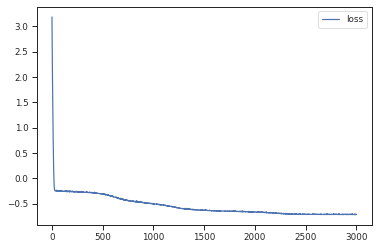

In [55]:
hist_df = pd.DataFrame(hist.history)
hist_df.plot(), hist_df.loss.min()

### Testing

In [56]:
x_test = np.ones((1, 1), dtype='float32')

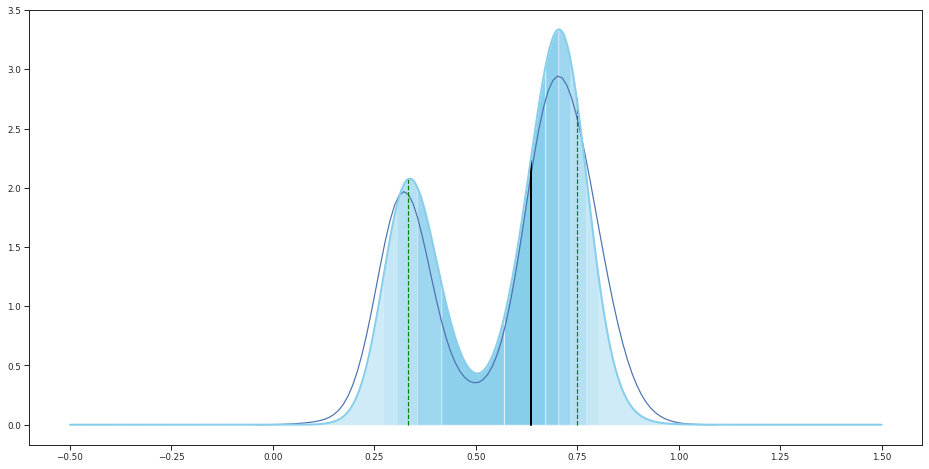

In [57]:
flow = flow_model(x_test)
yy = np.linspace(-0.5, 1.5, 1000, dtype=np.float32)
plt.figure(figsize=(16, 8))
sns.kdeplot(y)
plot_flow(flow, yy[..., None])

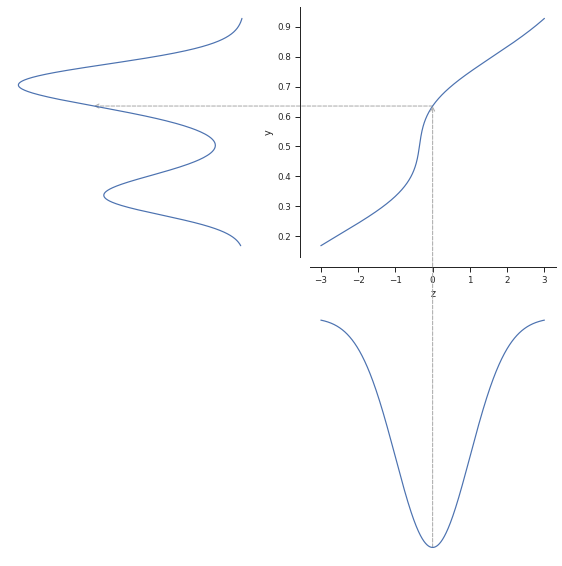

In [58]:
fig=vizualize_flow_from_z_domain(flow)

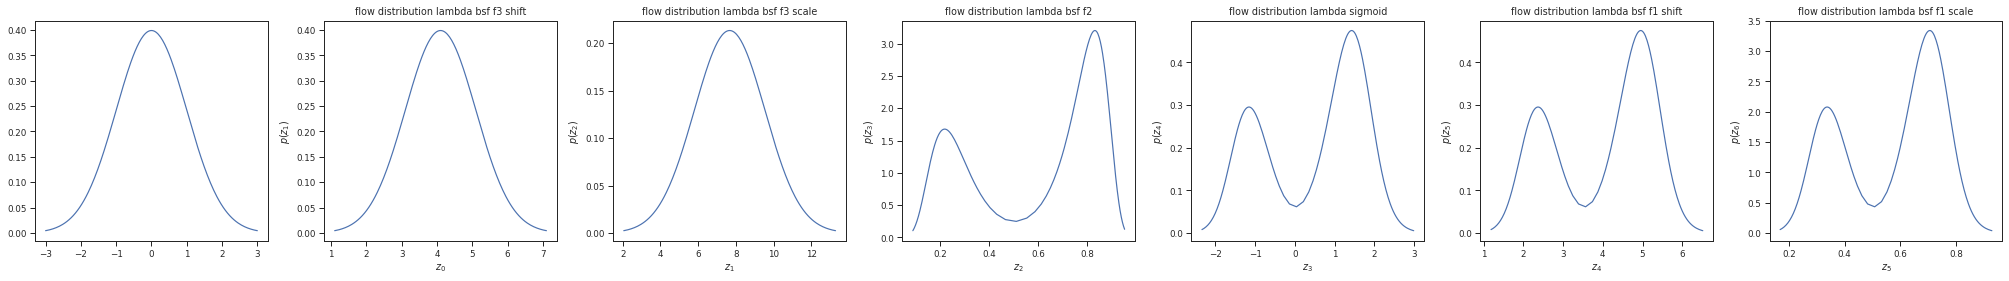

In [59]:
plot_chained_bijectors(flow)

In [60]:
b2 = flow.bijector.bijector.bijectors[0].shift
a2 = flow.bijector.bijector.bijectors[1].scale
theta = flow.bijector.bijector.bijectors[2].theta
b1 = flow.bijector.bijector.bijectors[4].shift
a1 = flow.bijector.bijector.bijectors[5].scale

In [61]:
print(f"""
a1 = {repr(a1.numpy())}
b1 = {repr(b1.numpy())}
theta = {repr(theta.numpy())}
a2 = {repr(a2.numpy())}
b2 = {repr(b2.numpy())}
""")


a1 = 7.0266094
b1 = -3.5258875
theta = array([[-3.3345084,  7.003389 ,  7.008339 ,  7.0083394,  7.0083394,
         7.0083394,  7.00834  ,  7.008352 , 16.28672  ]], dtype=float32)
a2 = 0.5349127
b2 = -4.099924



## Berstein Bijector as Loss

The Bernstein bijector can also be used as a Keras loss function.

Lets define a small helper class to build and parametrize the Flow:

In [104]:
class BersteinFlow():
    def __init__(
            self,
            M):
        self.M = M

    def __call__(self, pvector):

        flow = self.gen_flow(pvector)

        return flow

    def slice_parameter_vectors(self, pvector):
        """ Returns an unpacked list of paramter vectors.
        """
        p_len = [1, 1, self.M, 1, 1]
        num_dist = pvector.shape[1]
        sliced_pvectors = []
        for d in range(num_dist):
            sliced_pvector = [pvector[:, d, sum(p_len[:i]):(
                sum(p_len[:i + 1]))] for i, p in enumerate(p_len)]
            sliced_pvectors.append(sliced_pvector)
        return sliced_pvectors

    def gen_flow(self, pvector):
        pvs = slice_parameter_vectors(pvector)
        flows = []
        for pv in pvs:
            a1, b1, theta, a2, b2 = pv

            flow = bernstein_flow(
                M=M,
                a1=tf.math.softplus(a1),
                b1=b1,
                theta=BernsteinBijector.constrain_theta(theta),
                a2=tf.math.softplus(a2),
                b2=b2
            )

            flows.append(flow)
        joint = tfd.JointDistributionSequential(flows, name='joint_bs_flows')
        blkws = tfd.Blockwise(joint)
        return blkws

Noe we can define a custom Bernstein loss function

In [105]:
class BersteinFlowLoss(Loss):
    def __init__(
            self,
            M,
            **kwargs):
        self.bernstein_flow = BersteinFlow(M)
        super().__init__(**kwargs)

    def call(self, y, pvector):

        flow = self.bernstein_flow(pvector)

        nll = -flow.log_prob(y)

        return nll

### Model Definition

In [96]:
neurons = 32  # Neurons of the DNN hidden layers
M = 9         # Order of Bernstin polynomial


OutputLayer = partial(
    tf.keras.layers.Dense,
    activation="linear",
    use_bias=False,
    # kernel_regularizer=tf.keras.regularizers.l2(0.0001)
)

inputs = tf.keras.layers.Input(shape=(1,))

pvector = OutputLayer(
    4+M,
    name="pvector"
)(inputs)

out = Reshape((1, -1))(pvector)

flow_parameter_model = tf.keras.Model(
    inputs=[inputs],
    outputs=[out],
    name='bs_loss')
flow_parameter_model.summary()

Model: "bs_loss"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
pvector (Dense)              (None, 13)                13        
_________________________________________________________________
reshape_2 (Reshape)          (None, 1, None)           0         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


In [97]:
x_sample, y_sample = next(dataset.as_numpy_iterator())
x_sample.shape, y_sample.shape

((32, 1), (32,))

In [108]:
flow_parameter_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss=BersteinFlowLoss(M)
)

### Training

In [109]:
# Do inference.
flow_parameter_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss=bernstein_loss
)
hist = flow_parameter_model.fit(
    dataset,
    epochs=3000,
    verbose=False
)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f1e6c303610>,
 -0.7209534645080566)

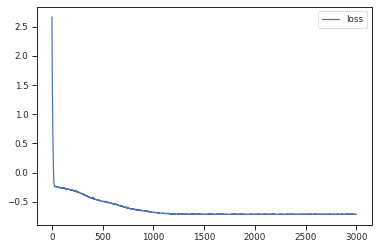

In [110]:
hist_df = pd.DataFrame(hist.history)
hist_df.plot(), hist_df.loss.min()

### Testing

In [124]:
x_test = np.ones((1, 1), dtype='float32')

In [125]:
pvs = flow_parameter_model(x_test)
flow = BersteinFlow(M)(pvs).distributions.model[0]

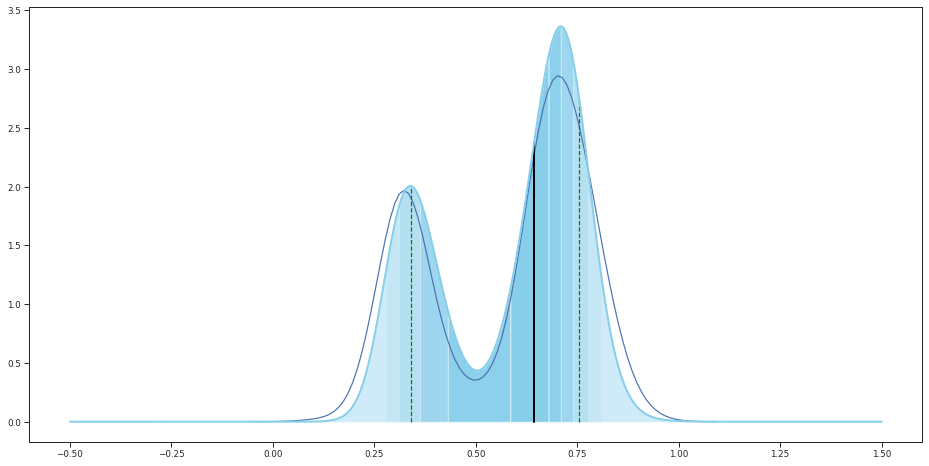

In [126]:
yy = np.linspace(-0.5, 1.5, 1000, dtype=np.float32)
plt.figure(figsize=(16, 8))
sns.kdeplot(y)
plot_flow(flow, yy[..., None])

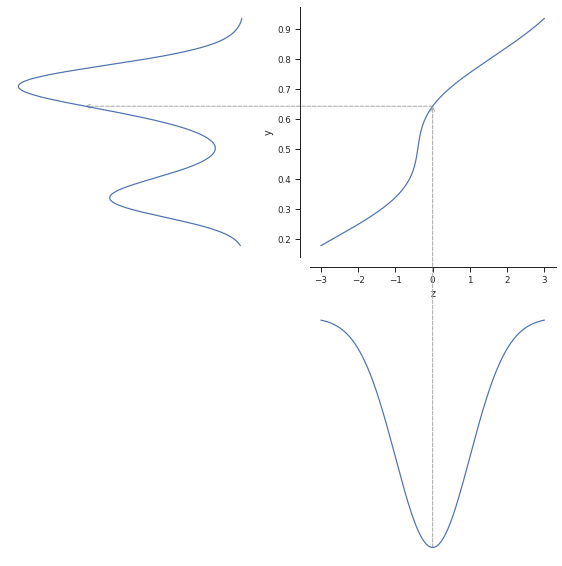

In [127]:
fig=vizualize_flow_from_z_domain(flow)

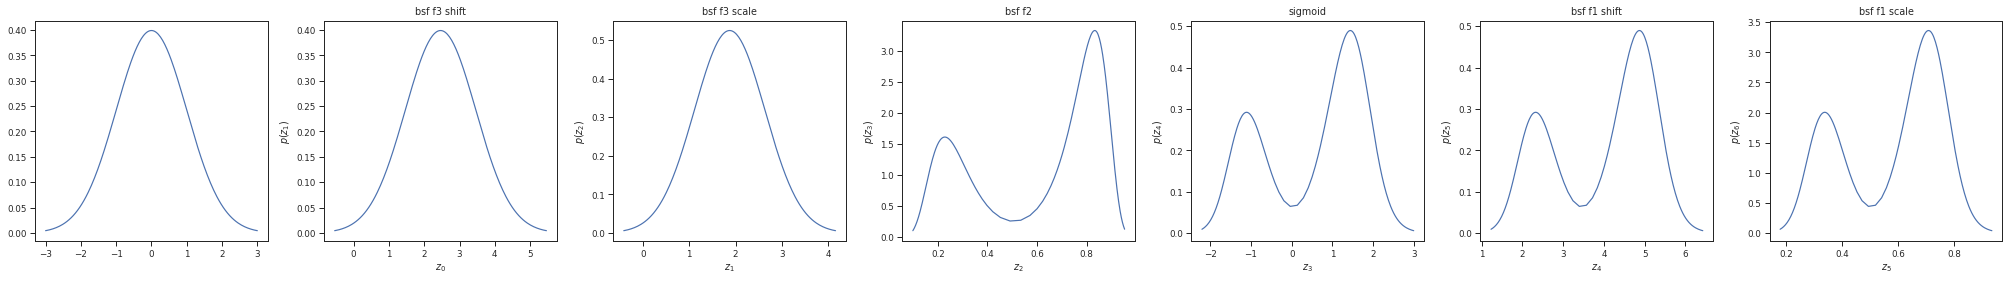

In [128]:
plot_chained_bijectors(flow)

In [131]:
b2 = flow.bijector.bijector.bijectors[0].shift.numpy().flatten()
a2 = flow.bijector.bijector.bijectors[1].scale.numpy().flatten()
theta = flow.bijector.bijector.bijectors[2].theta.numpy().flatten()
b1 = flow.bijector.bijector.bijectors[4].shift.numpy().flatten()
a1 = flow.bijector.bijector.bijectors[5].scale.numpy().flatten()

In [132]:
print(f"""
a1 = {repr(a1)}
b1 = {repr(b1)}
theta = {repr(theta)}
a2 = {repr(a2)}
b2 = {repr(b2)}
""")


a1 = array([6.8665323], dtype=float32)
b1 = array([-3.4331806], dtype=float32)
theta = array([-3.0079176,  1.5703747,  1.5703856,  1.5703856,  1.5703856,
        1.5703856,  1.5703856,  1.5703863,  5.3915358], dtype=float32)
a2 = array([1.3153383], dtype=float32)
b2 = array([-2.462406], dtype=float32)



# References

[<a id="cit-tabak-FamilyNonparametricDensity-2013" href="#call-tabak-FamilyNonparametricDensity-2013">1</a>] Tabak E. G. and Turner Cristina V., ``_A Family of Nonparametric Density Estimation Algorithms_'', , vol. 66, number 2, pp. 145--164,  2013.  [online](https://onlinelibrary.wiley.com/doi/abs/10.1002/cpa.21423)

[<a id="cit-papamakarios-NormalizingFlowsProbabilistic-2019" href="#call-papamakarios-NormalizingFlowsProbabilistic-2019">2</a>] Papamakarios George, Nalisnick Eric, Rezende Danilo Jimenez <em>et al.</em>, ``_Normalizing Flows for Probabilistic Modeling and Inference_'', , vol. , number , pp. ,  2019.  [online](http://arxiv.org/abs/1912.02762)

[<a id="cit-hothorn-MostLikelyTransformations-2018" href="#call-hothorn-MostLikelyTransformations-2018">3</a>] Hothorn Torsten, Möst Lisa and Bühlmann Peter, ``_Most Likely Transformations_'', , vol. 45, number 1, pp. 110--134,  2018.  [online](https://onlinelibrary.wiley.com/doi/abs/10.1111/sjos.12291)

[<a id="cit-sick-DeepTransformationModels-2020" href="#call-sick-DeepTransformationModels-2020">4</a>] Sick Beate, Hothorn Torsten and Dürr Oliver, ``_Deep transformation models: Tackling complex regression problems with neural network based transformation models_'', , vol. , number , pp. ,  2020.  [online](http://arxiv.org/abs/2004.00464)

[<a id="cit-farouki-BernsteinPolynomialBasis-2012" href="#call-farouki-BernsteinPolynomialBasis-2012">5</a>] Farouki Rida T., ``_The Bernstein polynomial basis: A centennial retrospective_'', , vol. 29, number 6, pp. 379--419,  2012.  [online](https://doi.org/10.1016/j.cagd.2012.03.001)

[<a id="cit-kingma-ImprovingVariationalInference-2017" href="#call-kingma-ImprovingVariationalInference-2017">6</a>] Kingma Diederik P., Salimans Tim, Jozefowicz Rafal <em>et al.</em>, ``_Improving Variational Inference with Inverse Autoregressive Flow_'', , vol. , number , pp. ,  2017.  [online](http://arxiv.org/abs/1606.04934)

[<a id="cit-rezende-VariationalInferenceNormalizing-2016" href="#call-rezende-VariationalInferenceNormalizing-2016">7</a>] Rezende Danilo Jimenez and Mohamed Shakir, ``_Variational Inference with Normalizing Flows_'', , vol. , number , pp. ,  2016.  [online](http://arxiv.org/abs/1505.05770)

[<a id="cit-kingma-GlowGenerativeFlow-2018" href="#call-kingma-GlowGenerativeFlow-2018">8</a>] Kingma Diederik P. and Dhariwal Prafulla, ``_Glow: Generative Flow with Invertible 1x1 Convolutions_'', , vol. , number , pp. ,  2018.  [online](http://arxiv.org/abs/1807.03039)

[<a id="cit-dinh-DensityEstimationUsing-2017" href="#call-dinh-DensityEstimationUsing-2017">9</a>] Dinh Laurent, Sohl-Dickstein Jascha and Bengio Samy, ``_Density estimation using Real NVP_'', , vol. , number , pp. ,  2017.  [online](http://arxiv.org/abs/1605.08803)

[<a id="cit-oord-ParallelWaveNetFast-2017" href="#call-oord-ParallelWaveNetFast-2017">10</a>] van den Oord Aaron, Li Yazhe, Babuschkin Igor <em>et al.</em>, ``_Parallel WaveNet: Fast High-Fidelity Speech Synthesis_'', , vol. , number , pp. ,  2017.  [online](http://arxiv.org/abs/1711.10433)

[<a id="cit-oord-WaveNetGenerativeModel-2016" href="#call-oord-WaveNetGenerativeModel-2016">11</a>] van den Oord Aaron, Dieleman Sander, Zen Heiga <em>et al.</em>, ``_WaveNet: A Generative Model for Raw Audio_'', , vol. , number , pp. ,  2016.  [online](http://arxiv.org/abs/1609.03499)

[<a id="cit-sohn-LearningStructuredOutput-2015" href="#call-sohn-LearningStructuredOutput-2015">12</a>] K. Sohn, H. Lee and X. Yan, ``_Learning structured output representation using deep conditional generative models_'', Advances in neural information processing systems 28,  2015.  [online](http://papers.nips.cc/paper/5775-learning-structured-output-representation-using-deep-conditional-generative-models.pdf)

[<a id="cit-mirza-ConditionalGenerativeAdversarial-2014" href="#call-mirza-ConditionalGenerativeAdversarial-2014">13</a>] Mirza Mehdi and Osindero Simon, ``_Conditional Generative Adversarial Nets_'', , vol. , number , pp. ,  2014.  [online](http://arxiv.org/abs/1411.1784)

[<a id="cit-rothfuss-NoiseRegularizationConditional-2020" href="#call-rothfuss-NoiseRegularizationConditional-2020">14</a>] Rothfuss Jonas, Ferreira Fabio, Boehm Simon <em>et al.</em>, ``_Noise Regularization for Conditional Density Estimation_'', , vol. , number , pp. ,  2020.  [online](http://arxiv.org/abs/1907.08982)

[<a id="cit-rasul-MultivariateProbabilisticTime-2020" href="#call-rasul-MultivariateProbabilisticTime-2020">15</a>] Rasul Kashif, Sheikh Abdul-Saboor, Schuster Ingmar <em>et al.</em>, ``_Multi-variate Probabilistic Time Series Forecasting via Conditioned Normalizing Flows_'', , vol. , number , pp. ,  2020.  [online](http://arxiv.org/abs/2002.06103)

[<a id="cit-trippe-ConditionalDensityEstimation-2018" href="#call-trippe-ConditionalDensityEstimation-2018">16</a>] Trippe Brian L. and Turner Richard E., ``_Conditional Density Estimation with Bayesian Normalising Flows_'', , vol. , number , pp. ,  2018.  [online](http://arxiv.org/abs/1802.04908)

[<a id="cit-weng-FlowbasedDeepGenerative-2018" href="#call-weng-FlowbasedDeepGenerative-2018">17</a>] Weng Lilian, ``_Flow-based deep generative models_'', , vol. , number , pp. ,  2018.  [online](http://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html)

